In [ ]:
!pip install --upgrade xgboost

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, silhouette_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import entropy

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the training data
df_train = pd.read_excel(
    '/dataset.xlsx', # Path to the training dataset
    engine='openpyxl')

# Load the testing data
df_test = pd.read_excel(
    '/dataset.xlsx', # Path to the testing dataset
    engine='openpyxl')

# Corporate set features
FEATURES = ['avg_monthly_cash_transaction_amount',
        'avg_monthly_cash_transaction_count',
        'sum_monthly_cash_transaction_amount',
        'max_monthly_cash_transaction_amount',
        'avg_monthly_cross_border_transaction_amount',
        'avg_monthly_cross_border_transaction_count',
        'sum_monthly_cross_border_transaction_amount',
        'max_monthly_cross_border_transaction_amount',
        'market_area',
        'industry_group',
        'turnover_bucket',
        'company_size_M']

# Retail set features
'''
FEATURES = ['avg_monthly_cash_transaction_amount',
        'avg_monthly_cash_transaction_count',
        'sum_monthly_cash_transaction_amount',
        'max_monthly_cash_transaction_amount',
        'avg_monthly_cross_border_transaction_amount',
        'avg_monthly_cross_border_transaction_count',
        'sum_monthly_cross_border_transaction_amount',
        'max_monthly_cross_border_transaction_amount',
        'market_area',
        'turnover_bucket',
        'age_group']
'''

# Function to prepare features
def prepare_features(df):
    # Create a copy to avoid modifying the original dataframe
    df_processed = df.copy()

    # Print number of records before feature preparation
    print(f"Number of records before feature preparation: {len(df_processed)}")

    # Check for missing values
    missing_values = df_processed[FEATURES].isnull().sum()
    if missing_values.any():
        print("\nMissing values in features:")
        print(missing_values[missing_values > 0])

    # Include all features
    features = df_processed[FEATURES]

    # Convert all columns to float
    features = features.astype(float)

    # Print number of records after feature preparation
    print(f"Number of records after feature preparation: {len(features)}")

    return features

In [ ]:
# Prepare features separately for training and test data
print("\nPreparing training features:")
X_train = prepare_features(df_train)
print("\nPreparing test features:")
X_test = prepare_features(df_test)

# Prepare labels for training data
y_train = df_train['Segment']

# Encode target variable to start from 0
target_encoder = LabelEncoder()
y_train_encoded = target_encoder.fit_transform(y_train)

# Get number of unique classes
n_classes = len(np.unique(y_train_encoded))

# Split training data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_encoded, test_size=0.2, random_state=42
)

xgb_clf = xgb.XGBClassifier(
    reg_lambda=1.0,  # L2 regularization
    reg_alpha=0.1,   # L1 regularization
    max_depth=2,     # Reduce to limit model complexity
    min_child_weight=3,  # Increase to prevent over-specialization
    objective='multi:softmax',
    num_class=n_classes,
    random_state=42,
    learning_rate=0.1,
    n_estimators=500,  # Increased max iterations since using early stopping
    eval_metric='mlogloss',
    early_stopping_rounds=10  # Stop if no improvement for 10 rounds
)

# Train the model with early stopping
xgb_clf.fit(
    X_train_split,
    y_train_split,
    eval_set=[(X_train_split, y_train_split), (X_val, y_val)],
    verbose=True
)

# Print best iteration information
print(f"\nBest iteration found: {xgb_clf.best_iteration}")
print(f"Best validation score: {xgb_clf.best_score}")

# Make predictions on validation set
y_val_pred = xgb_clf.predict(X_val)

# Convert predictions back to original labels for reporting
y_val_orig = target_encoder.inverse_transform(y_val)
y_val_pred_orig = target_encoder.inverse_transform(y_val_pred)

# Print metrics for validation set
print("\nValidation Metrics:")
print("Accuracy:", accuracy_score(y_val_orig, y_val_pred_orig))
print("\nClassification Report:")
print(classification_report(y_val_orig, y_val_pred_orig))
print("\nMacro F1 Score:", f1_score(y_val_orig, y_val_pred_orig, average='macro'))

# Make predictions on test set
y_test_pred = xgb_clf.predict(X_test)

# Convert predictions back to original labels
y_test_pred_orig = target_encoder.inverse_transform(y_test_pred)

# Save predictions to a DataFrame
predictions_df = pd.DataFrame({
    'Predicted_Segment': y_test_pred_orig
})

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_clf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 3 Most Important Features:")
print(feature_importance.head(3))

In [ ]:
# Make predictions on test set
y_test_pred = xgb_clf.predict(X_test)

# Convert predictions back to original labels
y_test_pred_orig = target_encoder.inverse_transform(y_test_pred)

# Create distribution analysis for test predictions
test_distribution = pd.DataFrame({
    'Predicted_Segment': y_test_pred_orig
})

# Calculate and print segment distribution
print("\nTest Set Segment Distribution:")
segment_counts = test_distribution['Predicted_Segment'].value_counts()
segment_percentages = test_distribution['Predicted_Segment'].value_counts(normalize=True) * 100

distribution_summary = pd.DataFrame({
    'Count': segment_counts,
    'Percentage': segment_percentages
}).round(2)

print(distribution_summary)

# Verify final prediction count
print(f"\nNumber of predictions made: {len(y_test_pred_orig)}")
print(f"Original test set size: {len(df_test)}")

# Save predictions with original indices
predictions_df = pd.DataFrame({
    'Predicted_Segment': y_test_pred_orig
}, index=df_test.index)


Test Set Segment Distribution:
                   Count  Percentage
Predicted_Segment                   
1                  34155       69.65
2                  14882       30.35

Number of predictions made: 49037
Original test set size: 49037



Training Set Segment Distribution (for comparison):
         Count  Percentage
Segment                   
1        33774       50.18
2        33537       49.82

Comparison of Segment Distributions (Training vs Test):
   Train_Count  Train_Percentage  Test_Count  Test_Percentage
1        33774             50.18       34155            69.65
2        33537             49.82       14882            30.35


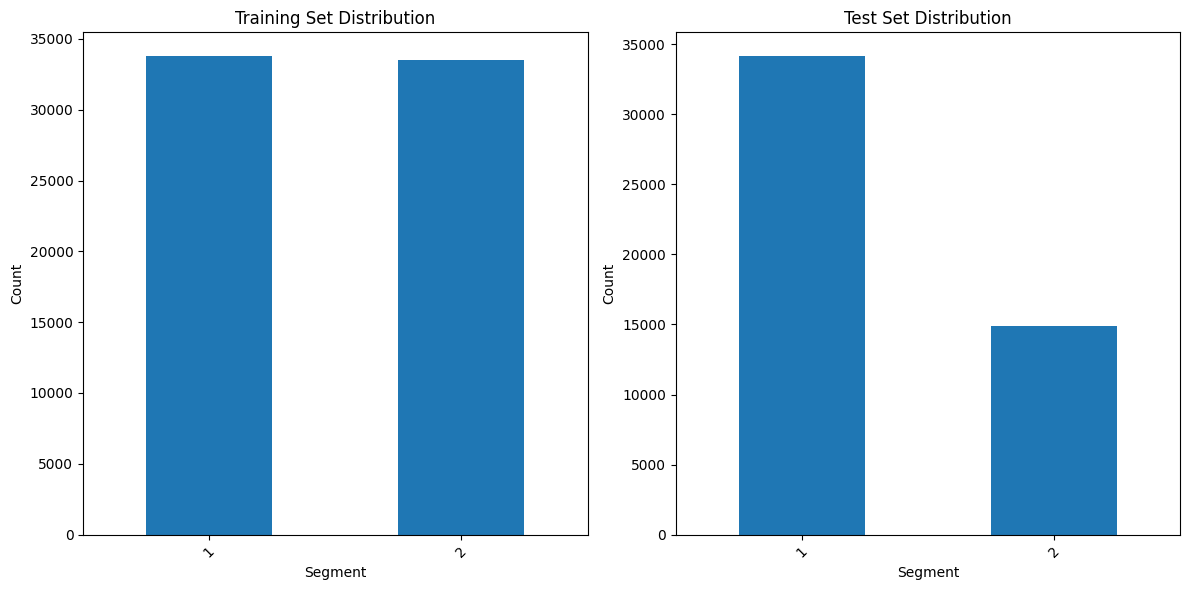

In [ ]:
# Compare with training distribution
print("\nTraining Set Segment Distribution (for comparison):")
train_distribution = pd.DataFrame({
    'Segment': y_train
})
train_segment_counts = train_distribution['Segment'].value_counts()
train_segment_percentages = train_distribution['Segment'].value_counts(normalize=True) * 100

train_distribution_summary = pd.DataFrame({
    'Count': train_segment_counts,
    'Percentage': train_segment_percentages
}).round(2)

print(train_distribution_summary)

# Create a side-by-side comparison
comparison_df = pd.DataFrame({
    'Train_Count': train_segment_counts,
    'Train_Percentage': train_segment_percentages,
    'Test_Count': segment_counts,
    'Test_Percentage': segment_percentages
}).round(2)

print("\nComparison of Segment Distributions (Training vs Test):")
print(comparison_df)

# Visualize the comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
train_distribution['Segment'].value_counts().plot(kind='bar')
plt.title('Training Set Distribution')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
test_distribution['Predicted_Segment'].value_counts().plot(kind='bar')
plt.title('Test Set Distribution')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Standardize features for distance-based metrics
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# 1. Calculate Silhouette Score
silhouette_avg = silhouette_score(X_test_scaled, y_test_pred)

# 2. Calculate cluster-specific metrics
def calculate_cluster_metrics(X, labels):
    n_clusters = len(np.unique(labels))
    cluster_centers = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])

    # Within-cluster sum of squares
    wcss = np.zeros(n_clusters)
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            wcss[i] = np.sum((cluster_points - cluster_centers[i]) ** 2)

    # Between-cluster distances
    between_cluster_dist = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            dist = np.linalg.norm(cluster_centers[i] - cluster_centers[j])
            between_cluster_dist[i, j] = dist
            between_cluster_dist[j, i] = dist

    return wcss, between_cluster_dist, cluster_centers

wcss, between_cluster_dist, cluster_centers = calculate_cluster_metrics(X_test_scaled, y_test_pred)

# 3. Calculate distribution entropy
cluster_proportions = np.unique(y_test_pred, return_counts=True)[1] / len(y_test_pred)
distribution_entropy = entropy(cluster_proportions)

# Print all metrics
print("\nUnsupervised Evaluation Metrics:")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"\nWithin-cluster sum of squares for each cluster:")
for i, score in enumerate(wcss):
    print(f"Cluster {i+1}: {score:.4f}")

print(f"\nBetween-cluster distances:")
print(between_cluster_dist)

print(f"\nDistribution Entropy: {distribution_entropy:.4f}")

# Calculate and print average distance to cluster center for each cluster
print("\nAverage distance to cluster center:")
for i in range(len(np.unique(y_test_pred))):
    cluster_points = X_test_scaled[y_test_pred == i]
    if len(cluster_points) > 0:
        avg_dist = np.mean(np.linalg.norm(cluster_points - cluster_centers[i], axis=1))
        print(f"Cluster {i+1}: {avg_dist:.4f}")